In [2]:
import tensorflow as tf
import pathlib
import PIL
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.tools import freeze_graph
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

## See and test dataset

In [3]:
DATA_SET_DIR = './dataset/'

In [4]:
data_dir = pathlib.Path(DATA_SET_DIR)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

392

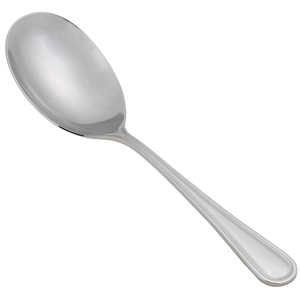

In [6]:
spoons = list(data_dir.glob('spoon/*'))
forks = list(data_dir.glob('fork/*'))
neither = list(data_dir.glob('neither/*'))

PIL.Image.open(spoons[0])

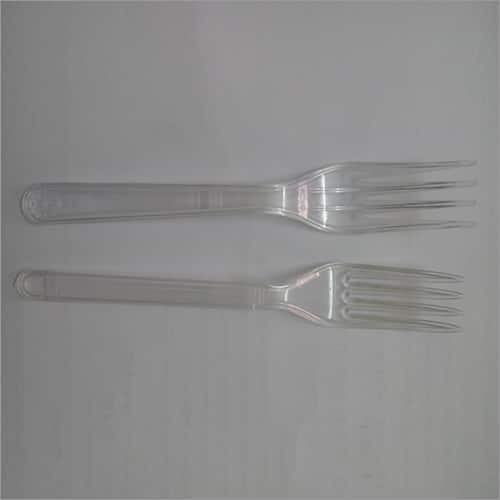

In [7]:
PIL.Image.open(forks[0])

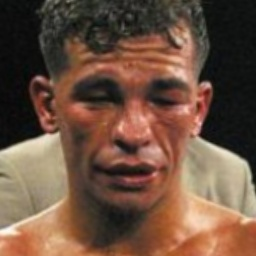

In [8]:
PIL.Image.open(neither[0])

## Load Dataset with Keras

In [25]:
image_height = 250
image_width = 250
batch_size = 64

In [26]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)


Found 435 files belonging to 3 classes.
Using 348 files for training.
Found 435 files belonging to 3 classes.
Using 87 files for validation.


In [27]:
class_names = train_ds.class_names
class_names

['fork', 'neither', 'spoon']

## Preprocess Dataset

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [60]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

## Create Model

In [61]:
num_classes = len(class_names)

In [64]:
data_augmentation = tf.keras.models.Sequential(
  [
    tf.keras.layers.RandomFlip("vertical",
                      input_shape=(image_height,
                                  image_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [71]:
model = tf.keras.models.Sequential([
    data_augmentation,
    normalization_layer,
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [72]:
optimizer_function = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [73]:
model.compile(optimizer=optimizer_function,
              loss=loss_function,
              metrics=['accuracy'])

In [74]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 250, 250, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 125, 125, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                

## Train Model

In [ ]:
epochs=12
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/12


2022-09-20 10:08:30.706270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 29.1328 - accuracy: 0.3391

2022-09-20 10:08:45.221913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 17s 2s/step - loss: 29.1328 - accuracy: 0.3391 - val_loss: 1.1076 - val_accuracy: 0.1839
Epoch 2/12
6/6 [==============================] - 12s 2s/step - loss: 1.4416 - accuracy: 0.3161 - val_loss: 1.0956 - val_accuracy: 0.3793
Epoch 3/12
6/6 [==============================] - 13s 2s/step - loss: 1.0942 - accuracy: 0.3391 - val_loss: 1.0860 - val_accuracy: 0.3793
Epoch 4/12
6/6 [==============================] - 13s 2s/step - loss: 1.0868 - accuracy: 0.3649 - val_loss: 1.0763 - val_accuracy: 0.4483
Epoch 5/12
2/6 [=========>....................] - ETA: 9s - loss: 1.0753 - accuracy: 0.4531 

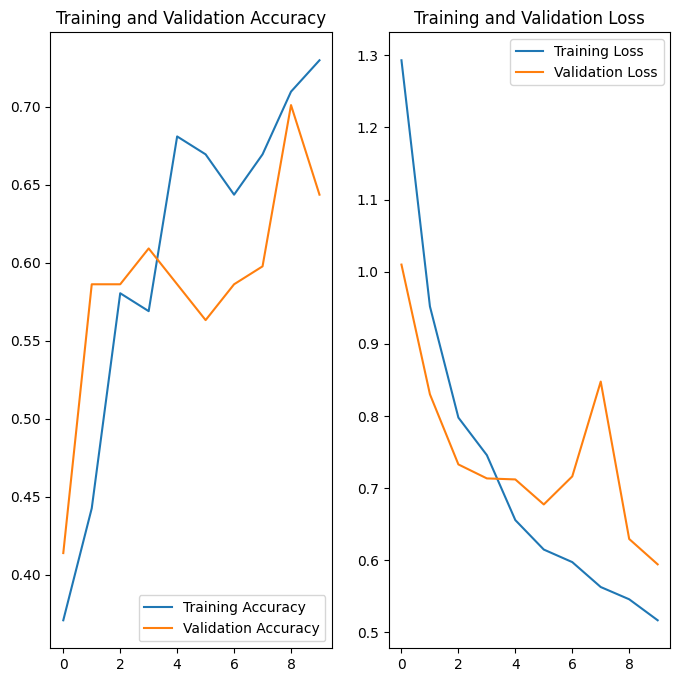

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save Model as h5 or pb

In [65]:
model.save('model1.5.h5')
#model.save('model1.1.pb')

## Save Model as Frozen Graph

In [26]:
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

In [27]:
frozen_func = convert_variables_to_constants_v2(full_model)
graph_def = frozen_func.graph.as_graph_def()

2022-09-17 15:38:26.418889: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-09-17 15:38:26.419118: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-09-17 15:38:26.419835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-17 15:38:26.419911: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [28]:
# Export frozen graph
with tf.io.gfile.GFile('frozen_graph.pb', 'wb') as f:
    f.write(graph_def.SerializeToString())